# **CLARA — MVSA-Single for Multimodal Sentiment (image + text) with CLIP+LoRA, DeBERTa+LoRA, Co-Attn, Verification+Uncertainty**

## **(0) Installing Library**

In [ ]:

# =========================
# (0) CÀI THƯ VIỆN/PIN VER
# =========================
import sys, importlib
def _pip_quiet(pkgs):
    import subprocess
    for p in pkgs:
        try:
            importlib.import_module(p.split("[")[0].split("==")[0])
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", p])

_pip_quiet([
    "transformers==4.42.4",
    "peft==0.11.1",
    "accelerate>=0.33.0",
    "kaleido"
])


## **(1) IMPORTS & CONFIG**

In [ ]:
# =========================
# (1) IMPORTS & SETUP
# =========================
print("="*76)
print("🚀 CLARA (v0.83+) — MVSA-Single, CLIP+LoRA safe adapter")
print("="*76)

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("✅ Google Drive mounted")
except Exception:
    print("⚠️  Not in Colab environment")

import os, random, warnings
from pathlib import Path
from dataclasses import dataclass
from typing import List
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW

from transformers import (
    CLIPProcessor, CLIPVisionModel,
    DebertaV2Tokenizer, DebertaV2Model,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, TaskType

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import plotly.graph_objects as go

warnings.filterwarnings("ignore")

CONFIG = {
    # === Paths ===
    'text_dir':   "/content/drive/MyDrive/MIT/DeCuong/MVSA/Dataset/MVSA_Single/data",
    'label_file': "/content/drive/MyDrive/MIT/DeCuong/MVSA/Dataset/MVSA_Single/labelResultAll.txt",

    # === Models ===
    'vision_model_id': "openai/clip-vit-base-patch32",
    'text_model_id':   "microsoft/deberta-v3-base",

    # === Fusion ===
    'hidden_dim': 512,
    'num_classes': 3,
    'coattn_layers': 2,
    'coattn_heads': 8,
    'coattn_dropout': 0.1,

    # === LoRA ===
    'enable_clip_lora': True,                 # BẬT LoRA cho CLIP (đã an toàn)
    'lora_clip': { 'r': 32,  'alpha': 64, 'dropout': 0.05 },
    'lora_deb':  { 'r': 64, 'alpha': 128, 'dropout': 0.10 },
    'unfreeze_deberta_last': True,

    # === Train ===
    'batch_size': 16,      # 8 nếu OOM
    'learning_rate': 1e-4,
    'weight_decay': 0.01,
    'max_epochs': 50,
    'early_stopping_patience': 12,
    'warmup_ratio': 0.1,

    # === Split ===
    'require_agreement': True,
    'train_ratio': 0.7, 'val_ratio': 0.15, 'test_ratio': 0.15,

    # === Data / System ===
    'max_length_percentile': 98,
    'max_length_sample_size': 1000,
    'amp_prefer_bf16': True,
    'grad_checkpointing': True,
    'num_workers': 2,
    'pin_memory': True,

    # === CLARA losses ===
    'use_contrastive': True,
    'contrastive_weight': 0.05,

    'seed': 42,
}

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(CONFIG['seed'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device: {device}")
if torch.cuda.is_available():
    print("   GPU:", torch.cuda.get_device_name(0))


🚀 CLARA (v0.83+) — MVSA-Single, CLIP+LoRA safe adapter
Mounted at /content/drive
✅ Google Drive mounted
✅ Device: cuda
   GPU: NVIDIA L4


## **(2) DATA LOADING — MVSA-Single**

In [ ]:
@dataclass
class MVSASample:
    image_path: str
    text_path: str
    label: str
    image_id: str
    ann1: str
    ann2: str
    agreement: bool
    @property
    def text(self):
        if not hasattr(self, '_text_cache'):
            try:
                with open(self.text_path, 'r', encoding='utf-8', errors='ignore') as f:
                    self._text_cache = f.read().strip()
            except Exception:
                self._text_cache = ""
        return self._text_cache

class MVSALoader:
    def __init__(self, text_dir: str, label_file: str):
        self.text_dir = Path(text_dir)
        self.label_file = Path(label_file)
        self.samples: List[MVSASample] = []
        self.label_names = ['positive', 'neutral', 'negative']
    def load(self, require_agreement=True):
        print("\n📂 Loading labels & building samples...")
        lbl = {}
        with open(self.label_file, 'r', encoding='utf-8') as f:
            for line in f:
                p=line.strip().split('\t')
                if len(p)>=2:
                    img_id=p[0]; anns=p[1].split(',')
                    if len(anns)>=2:
                        a1=anns[0].strip().lower(); a2=anns[1].strip().lower()
                        agr=(a1==a2)
                        if require_agreement and not agr: continue
                        lbl[img_id]={'ann1':a1,'ann2':a2,'label':a1,'agreement':agr}
        txt_files={f.stem:f for f in self.text_dir.glob('*.txt')}
        img_exts=['.jpg','.JPG','.jpeg','.JPEG','.png','.PNG']
        for img_id,info in lbl.items():
            if img_id not in txt_files: continue
            ip=None
            for e in img_exts:
                p=self.text_dir/f"{img_id}{e}"
                if p.exists(): ip=p; break
            if ip is None: continue
            self.samples.append(MVSASample(
                image_path=str(ip), text_path=str(txt_files[img_id]),
                label=info['label'], image_id=img_id,
                ann1=info['ann1'], ann2=info['ann2'], agreement=info['agreement']
            ))
        c=Counter([s.label for s in self.samples])
        print(f"  ✓ Total={len(self.samples)} | Pos={c.get('positive',0)} Neu={c.get('neutral',0)} Neg={c.get('negative',0)}")
        return self.samples
    def split(self, tr=0.7, va=0.15, seed=42):
        random.seed(seed)
        groups={'positive':[], 'neutral':[], 'negative':[]}
        for s in self.samples: groups[s.label].append(s)
        T,V,E=[],[],[]
        for _,lst in groups.items():
            random.shuffle(lst); n=len(lst); ntr=int(n*tr); nva=int(n*va)
            T+=lst[:ntr]; V+=lst[ntr:ntr+nva]; E+=lst[ntr+nva:]
        random.shuffle(T); random.shuffle(V); random.shuffle(E)
        return T,V,E

loader = MVSALoader(CONFIG['text_dir'], CONFIG['label_file'])
all_samples = loader.load(CONFIG['require_agreement'])
train_samples, val_samples, test_samples = loader.split(CONFIG['train_ratio'], CONFIG['val_ratio'], CONFIG['seed'])
print(f"📦 Split → Train={len(train_samples)} | Val={len(val_samples)} | Test={len(test_samples)}")



📂 Loading labels & building samples...
  ✓ Total=2592 | Pos=1398 Neu=470 Neg=724
📦 Split → Train=1813 | Val=387 | Test=392


## **(3) EDA**


📄 10 sample TEXT:
[01] id=3181 | label=neutral  | text: With temperatures around 90 and the humidity the result is the heat index below. Take it slow with the intense heat.
[02] id=2700 | label=neutral  | text: Why are you feeling dismal? Take the quiz:
[03] id=2468 | label=positive | text: RT @DeShobhaa: Trust me, the mood in Greece is optimistic and buoyant. I took this image yesterday.
[04] id=2713 | label=neutral  | text: RT @ScheinerLaw: @ThompsonKnight (Dallas) dumped disorganized discovery on @GWDLAW1 in box. Clever or crass?? http:/
[05] id=2319 | label=neutral  | text: We attached a leader swivel
[06] id=2105 | label=negative | text: RT @queenwaldorff: #ANIMALABUSE #CRUELTY #TORTURE #ABUSED #BURIED BART THE #ZOMBIE CAT eats for the first time http:
[07] id=3884 | label=negative | text: Feeling weepy. Marcee brings me cake & tea. Does this make me part of #blessed twitter or...
[08] id=2559 | label=positive | text: RT @assassinscreed: Both assassins crushed it at the #Assassin

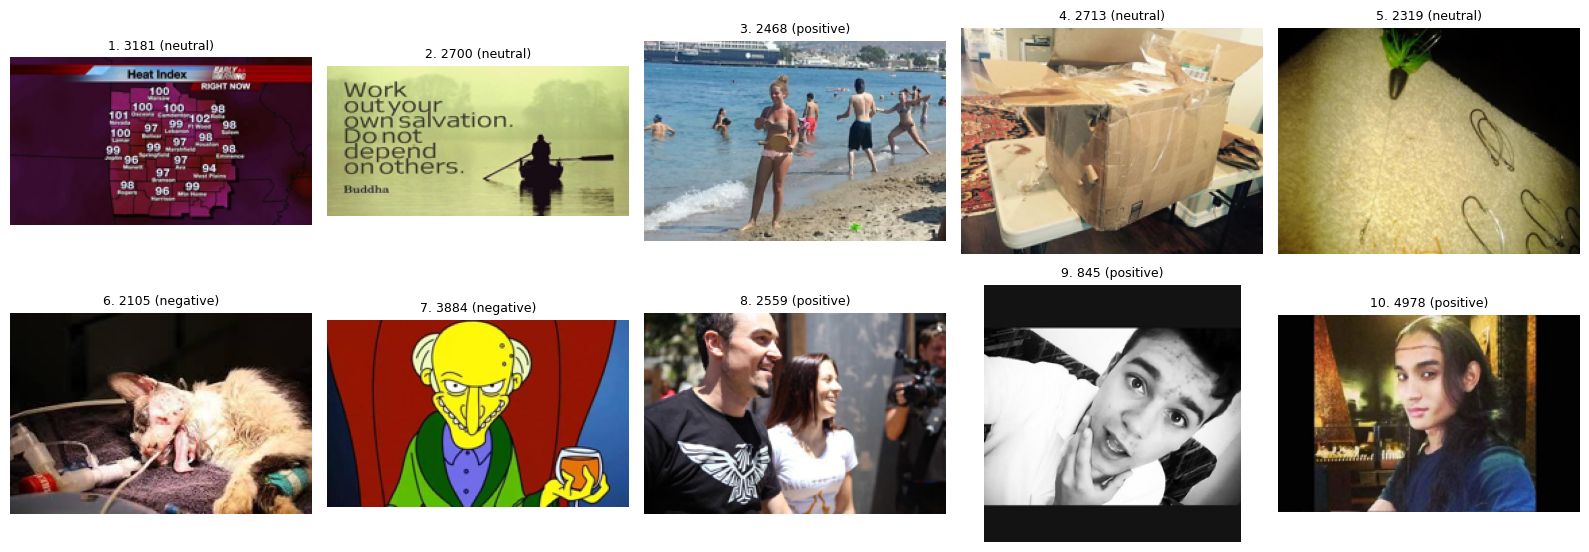

📊 Distribution...


In [ ]:
# Show 10 sample TEXT

def show_sample_texts(samples, k=10, max_chars=200):
    print(f"\n📄 {min(k, len(samples))} sample TEXT:")
    for i, s in enumerate(samples[:k]):
        txt = s.text.replace("\n", " ").strip()
        if len(txt) > max_chars:
            txt = txt[:max_chars] + "…"
        print(f"[{i+1:02d}] id={s.image_id} | label={s.label:<8} | text: {txt}")

# Ví dụ: lấy từ train_samples (có thể đổi thành val_samples/test_samples)
show_sample_texts(train_samples, k=10)

# Show 10 sample IMAGE (grid 5x2)

import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images(samples, k=10, ncols=5, thumb=(224, 224)):
    k = min(k, len(samples))
    nrows = (k + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.8*nrows))
    if nrows == 1:
        axes = [axes]
    axes = [ax for row in axes for ax in (row if isinstance(row, (list, tuple, np.ndarray)) else [row])]

    for i in range(k):
        s = samples[i]
        ax = axes[i]
        try:
            img = Image.open(s.image_path).convert("RGB")
            img.thumbnail(thumb)
        except Exception:
            img = Image.new("RGB", thumb, (220, 220, 220))
        ax.imshow(img)
        ax.set_title(f"{i+1}. {s.image_id} ({s.label})", fontsize=9)
        ax.axis("off")


    for j in range(k, nrows*ncols):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

show_sample_images(train_samples, k=10, ncols=5)

def plot_distribution(train, val, test):
    data=[]
    for name,S in [('Train',train),('Val',val),('Test',test)]:
        for lab in ['positive','neutral','negative']:
            data.append({'Split':name,'Class':lab.capitalize(),'Count':sum(1 for s in S if s.label==lab)})
    df=pd.DataFrame(data)
    fig=go.Figure()
    for sp in ['Train','Val','Test']:
        d=df[df['Split']==sp]
        fig.add_trace(go.Bar(name=sp, x=d['Class'], y=d['Count'], text=d['Count'], textposition='auto'))
    fig.update_layout(title='Dataset Distribution', barmode='group', template='plotly_white', height=420)
    fig.show()

print("📊 Distribution...")
plot_distribution(train_samples, val_samples, test_samples)

## **(4) PROCESSORS + DATASET**

In [ ]:
print("\n📥 Loading processors...")
clip_processor = CLIPProcessor.from_pretrained(CONFIG['vision_model_id'])
deb_tokenizer  = DebertaV2Tokenizer.from_pretrained(CONFIG['text_model_id'])
print("✅ Processors ready")

# Max length
print("\n📏 Computing MAX_LENGTH...")
chk = random.sample(all_samples, min(CONFIG['max_length_sample_size'], len(all_samples)))
lens=[len(s.text.split()) for s in chk]
p=CONFIG['max_length_percentile']
max_len=int(np.percentile(lens, p)) if lens else 128
MAX_LENGTH=max(128, max_len)
print(f"   P{p}={max_len} → MAX_LENGTH={MAX_LENGTH}")

class MVSADataset(Dataset):
    def __init__(self, samples, clip_processor, tokenizer, max_length):
        self.samples=samples; self.cp=clip_processor; self.tk=tokenizer; self.max_len=max_length
        self.lab={'positive':0,'neutral':1,'negative':2}
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        s=self.samples[idx]
        try: img=Image.open(s.image_path).convert('RGB')
        except: img=Image.new('RGB',(224,224),(0,0,0))
        ie=self.cp(images=img, return_tensors='pt')
        te=self.tk(s.text, padding='max_length', truncation=True, max_length=self.max_len, return_tensors='pt')
        return {
            'pixel_values': ie['pixel_values'].squeeze(0),
            'input_ids': te['input_ids'].squeeze(0),
            'attention_mask': te['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.lab[s.label], dtype=torch.long)
        }

use_cuda = torch.cuda.is_available()
pin_mem = bool(CONFIG['pin_memory'] and use_cuda)

# Sampler cân lớp
lab2id={'positive':0,'neutral':1,'negative':2}
cnt = Counter([s.label for s in train_samples])
arr = np.array([cnt.get('positive',1), cnt.get('neutral',1), cnt.get('negative',1)], dtype=np.float32)
arr = np.clip(arr, 1.0, None)
inv = (arr.sum()/arr)
weights_per_sample = [inv[lab2id[s.label]] for s in train_samples]
train_sampler = WeightedRandomSampler(weights_per_sample, num_samples=len(weights_per_sample), replacement=True)

train_ds = MVSADataset(train_samples, clip_processor, deb_tokenizer, MAX_LENGTH)
val_ds   = MVSADataset(val_samples,   clip_processor, deb_tokenizer, MAX_LENGTH)
test_ds  = MVSADataset(test_samples,  clip_processor, deb_tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], sampler=train_sampler,
                          num_workers=CONFIG['num_workers'], pin_memory=pin_mem,
                          persistent_workers=False, prefetch_factor=2)
val_loader   = DataLoader(val_ds,   batch_size=CONFIG['batch_size'], shuffle=False,
                          num_workers=CONFIG['num_workers'], pin_memory=pin_mem,
                          persistent_workers=False, prefetch_factor=2)
test_loader  = DataLoader(test_ds,  batch_size=CONFIG['batch_size'], shuffle=False,
                          num_workers=CONFIG['num_workers'], pin_memory=pin_mem,
                          persistent_workers=False, prefetch_factor=2)
print(f"✅ DataLoaders → batch={CONFIG['batch_size']} | steps/train={len(train_loader)}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



📥 Loading processors...


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

✅ Processors ready

📏 Computing MAX_LENGTH...
   P98=24 → MAX_LENGTH=128
✅ DataLoaders → batch=16 | steps/train=114


## **(5) MODEL CLARA & ADAPTER**

In [ ]:

class CoAttentionBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim*4), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim*4, hidden_dim), nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(hidden_dim)
    def forward(self, q, kv):
        x,_ = self.attn(q,kv,kv)
        x = self.norm1(q + x)
        y = self.ffn(x)
        y = self.norm2(x + y)
        return y

class CoAttentionStack(nn.Module):
    def __init__(self, vision_dim, text_dim, hidden_dim, layers=2, heads=8, dropout=0.1):
        super().__init__()
        self.v_proj = nn.Linear(vision_dim, hidden_dim)
        self.t_proj = nn.Linear(text_dim, hidden_dim)
        self.blocks = nn.ModuleList([CoAttentionBlock(hidden_dim, heads, dropout) for _ in range(layers)])
    def forward(self, v_feat, t_feat):
        v = self.v_proj(v_feat).unsqueeze(1)
        t = self.t_proj(t_feat).unsqueeze(1)
        x=t; kv=v
        for blk in self.blocks: x=blk(x,kv)
        return x.squeeze(1)

class PredictionModule(nn.Module):
    def __init__(self, hidden_dim, num_classes, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.LayerNorm(hidden_dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self,h):
        logits=self.net(h); probs=F.softmax(logits, dim=-1); return logits, probs

class VerificationModule(nn.Module):
    def __init__(self, hidden_dim, num_classes, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.LayerNorm(hidden_dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self,h):
        logits=self.net(h); probs=F.softmax(logits, dim=-1); return logits, probs

class UncertaintyEstimator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(hidden_dim//2, 1), nn.Sigmoid()
        )
    def forward(self,h): return self.net(h)

class FeedbackModule(nn.Module):
    def __init__(self, hidden_dim, num_classes, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim+num_classes, hidden_dim), nn.LayerNorm(hidden_dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )
    def forward(self,h, v_signal):
        return self.net(torch.cat([h, v_signal], dim=-1))

def _collect_linear_leaf_names(model: nn.Module):
    names=set()
    for n,m in model.named_modules():
        if isinstance(m, nn.Linear): names.add(n.split('.')[-1].lower())
    return names

def find_targets_for_clip(model: nn.Module):
    names=_collect_linear_leaf_names(model)
    pref={"q_proj","k_proj","v_proj","out_proj"}
    cand=[n for n in names if n in pref]
    if cand: return cand
    if 'proj' in names: return ['proj']
    return ["q_proj","k_proj","v_proj","out_proj"]

def find_targets_for_deberta(model: nn.Module):
    names=_collect_linear_leaf_names(model)
    pref={"query_proj","key_proj","value_proj","o_proj"}
    cand=[n for n in names if n in pref]
    if cand: return cand
    pref2={"q_proj","k_proj","v_proj","out_proj"}
    cand=[n for n in names if n in pref2]
    if cand: return cand
    return ['dense']


class _VisionAdapter(nn.Module):
    def __init__(self, model_like: nn.Module):
        super().__init__()
        backbone = model_like
        for _ in range(5):
            if hasattr(backbone, "get_base_model"):
                try:
                    backbone = backbone.get_base_model(); continue
                except Exception:
                    pass
            if hasattr(backbone, "base_model") and isinstance(backbone.base_model, nn.Module):
                backbone = backbone.base_model; continue
            if hasattr(backbone, "model") and isinstance(backbone.model, nn.Module):
                backbone = backbone.model; continue
            if hasattr(backbone, "module") and isinstance(backbone.module, nn.Module):
                backbone = backbone.module; continue
            break
        self.backbone = backbone
    def forward(self, pixel_values, *args, **kwargs):
        return self.backbone(pixel_values=pixel_values)  # chỉ pixel_values

class CLARAModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg=cfg
        H=cfg['hidden_dim']; heads=cfg['coattn_heads']; layers=cfg['coattn_layers']

        print("\n🔧 Initializing CLARA Model …")
        _clip_raw = CLIPVisionModel.from_pretrained(cfg['vision_model_id'])
        _deb_raw  = DebertaV2Model.from_pretrained(cfg['text_model_id'])

        # Gradient checkpointing (nếu có)
        if cfg['grad_checkpointing']:
            vm = getattr(_clip_raw, 'vision_model', None)
            if vm is not None and hasattr(vm, 'gradient_checkpointing_enable'):
                vm.gradient_checkpointing_enable()
            if hasattr(_deb_raw, 'gradient_checkpointing_enable'):
                _deb_raw.gradient_checkpointing_enable()

        # CLIP + LoRA (on) | if you want to freeze: set enable_clip_lora=False
        if cfg['enable_clip_lora']:
            clip_targets = find_targets_for_clip(_clip_raw)
            lcfg = LoraConfig(
                r=cfg['lora_clip']['r'], lora_alpha=cfg['lora_clip']['alpha'],
                lora_dropout=cfg['lora_clip']['dropout'], bias="none",
                target_modules=clip_targets, task_type=TaskType.FEATURE_EXTRACTION
            )
            clip_lora = get_peft_model(_clip_raw, lcfg)
            self.vision = _VisionAdapter(clip_lora)
            print(f"   ✓ LoRA(CLIP) targets={clip_targets}")
        else:
            for p in _clip_raw.parameters(): p.requires_grad=False
            _clip_raw.eval()
            self.vision = _VisionAdapter(_clip_raw)
            print("   ✓ CLIP frozen (no LoRA)")

        # DeBERTa + LoRA (mạnh)
        deb_targets = find_targets_for_deberta(_deb_raw)
        lcfg_deb = LoraConfig(
            r=cfg['lora_deb']['r'], lora_alpha=cfg['lora_deb']['alpha'],
            lora_dropout=cfg['lora_deb']['dropout'], bias="none",
            target_modules=deb_targets, task_type=TaskType.FEATURE_EXTRACTION
        )
        self.text = get_peft_model(_deb_raw, lcfg_deb)
        print(f"   ✓ LoRA(DeBERTa) targets={deb_targets}")
        if cfg.get('unfreeze_deberta_last', True):
            try:
                last_layer = self.text.base_model.encoder.layer[-1]
                for p in last_layer.parameters(): p.requires_grad=True
                print("   ✓ Unfreeze last DeBERTa layer")
            except Exception:
                pass

        # Fusion + Heads
        self.fusion = CoAttentionStack(vision_dim=768, text_dim=768, hidden_dim=H,
                                       layers=layers, heads=heads, dropout=cfg['coattn_dropout'])
        self.pred  = PredictionModule(H, cfg['num_classes'])
        self.veri  = VerificationModule(H, cfg['num_classes'])
        self.unc   = UncertaintyEstimator(H)
        self.feed  = FeedbackModule(H, num_classes=cfg['num_classes'])
        print("✅ Model initialized")

    def forward(self, pixel_values, input_ids, attention_mask):
        # Vision (positional, NO kwargs)
        v_out = self.vision(pixel_values)
        v_feat = v_out.last_hidden_state.mean(dim=1)

        # Text (kwargs OK)
        t_out = self.text(input_ids=input_ids, attention_mask=attention_mask)
        t_seq = t_out.last_hidden_state
        mask = attention_mask.unsqueeze(-1).float()
        t_feat = (t_seq * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)

        fused = self.fusion(v_feat, t_feat)
        lg_p, pr_p = self.pred(fused)
        lg_v, pr_v = self.veri(fused)
        u = self.unc(fused)
        sig = pr_v - pr_p
        ref = self.feed(fused, sig)
        lg2, pr2 = self.pred(ref)
        return {'logits':lg2, 'probs':pr2, 'pred_logits':lg_p, 'verify_logits':lg_v, 'uncertainty':u}

    def print_stats(self):
        total=sum(p.numel() for p in self.parameters())
        trainable=sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"\n📊 Params: total={total:,} | trainable={trainable:,} ({trainable/max(total,1)*100:.2f}%)")

model = CLARAModel(CONFIG).to(device)
model.print_stats()


🔧 Initializing CLARA Model …


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

   ✓ LoRA(CLIP) targets=['v_proj', 'out_proj', 'k_proj', 'q_proj']
   ✓ LoRA(DeBERTa) targets=['value_proj', 'query_proj', 'key_proj']
   ✓ Unfreeze last DeBERTa layer
✅ Model initialized

📊 Params: total=285,467,911 | trainable=21,268,231 (7.45%)


## **(6) EARLY STOP & CLASS WEIGHTS**

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience=patience; self.min_delta=min_delta; self.counter=0
        self.best=None; self.epoch=0; self.stop=False
    def __call__(self, score, epoch):
        if self.best is None: self.best=score; self.epoch=epoch
        elif score>self.best+self.min_delta: self.best=score; self.epoch=epoch; self.counter=0
        else:
            self.counter+=1
            if self.counter>=self.patience: self.stop=True; print(f"\n⚠️  Early stopping @ best epoch {self.epoch}"); return True
        return False

counts = np.array([cnt.get('positive',0), cnt.get('neutral',0), cnt.get('negative',0)], dtype=np.float32)
counts = np.clip(counts, 1.0, None)
cls_weights = torch.tensor((counts.sum()/counts), device=device, dtype=torch.float)
print(f"Class weights: {cls_weights.tolist()}")

Class weights: [1.8537832498550415, 5.510638236999512, 3.5830039978027344]


## **(7) TRAINER**

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, cfg, device):
        self.model=model; self.tl=train_loader; self.vl=val_loader; self.cfg=cfg; self.device=device
        self.opt=AdamW(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['weight_decay'])
        steps=len(train_loader)*cfg['max_epochs']
        self.sche=get_linear_schedule_with_warmup(self.opt, int(cfg['warmup_ratio']*steps), steps)
        self.ce=nn.CrossEntropyLoss(weight=cls_weights, label_smoothing=0.05)
        self.early=EarlyStopping(patience=cfg['early_stopping_patience'])
        self.use_bf16 = bool(cfg['amp_prefer_bf16'] and torch.cuda.is_available() and torch.cuda.is_bf16_supported())
        self.amp_dtype = torch.bfloat16 if self.use_bf16 else torch.float16
        self.scaler = torch.cuda.amp.GradScaler(enabled=(not self.use_bf16 and torch.cuda.is_available()))
        print(f"AMP dtype: {'bf16' if self.use_bf16 else 'fp16'} (GradScaler enabled={self.scaler.is_enabled()})")
        self.best_f1=0.0; self.best_state=None

    def _contrastive(self, p_logits, v_logits):
        if not self.cfg['use_contrastive']: return torch.tensor(0.0, device=self.device)
        p = F.log_softmax(p_logits, dim=-1); q = F.softmax(v_logits, dim=-1)
        kl1 = F.kl_div(p, q, reduction='batchmean')
        p2 = F.softmax(p_logits, dim=-1); q2 = F.log_softmax(v_logits, dim=-1)
        kl2 = F.kl_div(q2, p2, reduction='batchmean')
        return 0.5*(kl1+kl2)

    def train_epoch(self):
        self.model.train(); total=0.0
        for b in tqdm(self.tl, desc="Training", leave=True, dynamic_ncols=True):
            pv=b['pixel_values'].to(self.device, non_blocking=True)
            ids=b['input_ids'].to(self.device, non_blocking=True)
            msk=b['attention_mask'].to(self.device, non_blocking=True)
            y=b['labels'].to(self.device, non_blocking=True)
            self.opt.zero_grad(set_to_none=True)
            ctx = torch.cuda.amp.autocast(dtype=self.amp_dtype) if torch.cuda.is_available() else torch.autocast('cpu', dtype=torch.bfloat16, enabled=False)
            with ctx:
                out=self.model(pv, input_ids=ids, attention_mask=msk)  # pv positional
                loss_main=self.ce(out['logits'], y)
                loss_ver =self.ce(out['verify_logits'], y)
                loss_con =F.kl_div(F.log_softmax(out['logits'],dim=-1), F.softmax(out['verify_logits'],dim=-1), reduction='batchmean')
                loss_ctr =self._contrastive(out['pred_logits'], out['verify_logits'])
                loss = loss_main + 0.35*loss_ver + 0.25*loss_con + self.cfg['contrastive_weight']*loss_ctr
            if self.scaler.is_enabled():
                self.scaler.scale(loss).backward(); torch.nn.utils.clip_grad_norm_(self.model.parameters(),1.0)
                self.scaler.step(self.opt); self.scaler.update()
            else:
                loss.backward(); torch.nn.utils.clip_grad_norm_(self.model.parameters(),1.0)
                self.opt.step()
            self.sche.step(); total+=loss.item()
        return total/max(len(self.tl),1)

    @torch.no_grad()
    def validate(self):
        self.model.eval(); P=[]; Y=[]
        for b in tqdm(self.vl, desc="Validation", leave=False):
            pv=b['pixel_values'].to(self.device, non_blocking=True)
            ids=b['input_ids'].to(self.device, non_blocking=True)
            msk=b['attention_mask'].to(self.device, non_blocking=True)
            y=b['labels'].to(self.device, non_blocking=True)
            out=self.model(pv, input_ids=ids, attention_mask=msk)  # pv positional
            P.extend(out['logits'].argmax(-1).cpu().numpy()); Y.extend(y.cpu().numpy())
        return accuracy_score(Y,P), f1_score(Y,P, average='macro')

    def train(self):
        print("\n"+"="*66); print("🚀 TRAINING STARTED"); print("="*66)
        for e in range(self.cfg['max_epochs']):
            tr=self.train_epoch(); va_acc,va_f1=self.validate()
            print(f"Epoch {e+1}/{self.cfg['max_epochs']} | Train Loss:{tr:.4f} | Val Acc:{va_acc:.4f} | Val F1:{va_f1:.4f}")
            if va_f1>self.best_f1:
                self.best_f1=va_f1; self.best_state={k:v.detach().cpu().clone() for k,v in self.model.state_dict().items()}
                print("  ✨ New best F1!")
            if self.early(va_f1, e): break
        if self.best_state is not None: self.model.load_state_dict(self.best_state)
        print(f"\n✅ Training complete! Best F1: {self.best_f1:.4f}")
        return self.best_f1

trainer = Trainer(model, train_loader, val_loader, CONFIG, device)
best_val_f1 = trainer.train()

AMP dtype: bf16 (GradScaler enabled=False)

🚀 TRAINING STARTED


Training:   0%|          | 0/114 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Training: 100%|██████████| 114/114 [00:30<00:00,  3.73it/s]


Epoch 1/50 | Train Loss:1.3813 | Val Acc:0.3178 | Val F1:0.2931
  ✨ New best F1!


Training: 100%|██████████| 114/114 [00:26<00:00,  4.23it/s]


Epoch 2/50 | Train Loss:1.0154 | Val Acc:0.5840 | Val F1:0.5978
  ✨ New best F1!


Training: 100%|██████████| 114/114 [00:27<00:00,  4.19it/s]


Epoch 3/50 | Train Loss:0.6138 | Val Acc:0.8010 | Val F1:0.7814
  ✨ New best F1!


Training: 100%|██████████| 114/114 [00:27<00:00,  4.16it/s]


Epoch 4/50 | Train Loss:0.4517 | Val Acc:0.8191 | Val F1:0.8001
  ✨ New best F1!


Training: 100%|██████████| 114/114 [00:26<00:00,  4.23it/s]


Epoch 5/50 | Train Loss:0.3671 | Val Acc:0.8191 | Val F1:0.7972


Training: 100%|██████████| 114/114 [00:26<00:00,  4.24it/s]


Epoch 6/50 | Train Loss:0.3587 | Val Acc:0.8450 | Val F1:0.8154
  ✨ New best F1!


Training: 100%|██████████| 114/114 [00:26<00:00,  4.25it/s]


Epoch 7/50 | Train Loss:0.3364 | Val Acc:0.8346 | Val F1:0.8046


Training: 100%|██████████| 114/114 [00:27<00:00,  4.22it/s]


Epoch 8/50 | Train Loss:0.2924 | Val Acc:0.8088 | Val F1:0.7841


Training: 100%|██████████| 114/114 [00:27<00:00,  4.18it/s]


Epoch 9/50 | Train Loss:0.2870 | Val Acc:0.8320 | Val F1:0.8056


Training: 100%|██████████| 114/114 [00:26<00:00,  4.25it/s]


Epoch 10/50 | Train Loss:0.2653 | Val Acc:0.8372 | Val F1:0.8164
  ✨ New best F1!


Training: 100%|██████████| 114/114 [00:26<00:00,  4.29it/s]


Epoch 11/50 | Train Loss:0.2686 | Val Acc:0.8010 | Val F1:0.7760


Training: 100%|██████████| 114/114 [00:26<00:00,  4.24it/s]


Epoch 12/50 | Train Loss:0.2473 | Val Acc:0.8346 | Val F1:0.8156


Training: 100%|██████████| 114/114 [00:27<00:00,  4.21it/s]


Epoch 13/50 | Train Loss:0.2574 | Val Acc:0.8372 | Val F1:0.8173
  ✨ New best F1!


Training: 100%|██████████| 114/114 [00:26<00:00,  4.25it/s]


Epoch 14/50 | Train Loss:0.2367 | Val Acc:0.8475 | Val F1:0.8251
  ✨ New best F1!


Training: 100%|██████████| 114/114 [00:26<00:00,  4.26it/s]


Epoch 15/50 | Train Loss:0.2385 | Val Acc:0.8243 | Val F1:0.8043


Training: 100%|██████████| 114/114 [00:26<00:00,  4.24it/s]


Epoch 16/50 | Train Loss:0.2722 | Val Acc:0.8295 | Val F1:0.8024


Training: 100%|██████████| 114/114 [00:26<00:00,  4.27it/s]


Epoch 17/50 | Train Loss:0.2409 | Val Acc:0.8269 | Val F1:0.8063


Training: 100%|██████████| 114/114 [00:26<00:00,  4.23it/s]


Epoch 18/50 | Train Loss:0.2512 | Val Acc:0.8372 | Val F1:0.8121


Training: 100%|██████████| 114/114 [00:26<00:00,  4.25it/s]


Epoch 19/50 | Train Loss:0.2514 | Val Acc:0.8165 | Val F1:0.7931


Training: 100%|██████████| 114/114 [00:26<00:00,  4.24it/s]


Epoch 20/50 | Train Loss:0.2248 | Val Acc:0.8372 | Val F1:0.8192


Training: 100%|██████████| 114/114 [00:26<00:00,  4.25it/s]


Epoch 21/50 | Train Loss:0.2374 | Val Acc:0.8191 | Val F1:0.7955


Training: 100%|██████████| 114/114 [00:27<00:00,  4.22it/s]


Epoch 22/50 | Train Loss:0.2441 | Val Acc:0.8398 | Val F1:0.8141


Training: 100%|██████████| 114/114 [00:27<00:00,  4.21it/s]


Epoch 23/50 | Train Loss:0.2371 | Val Acc:0.8346 | Val F1:0.8112


Training: 100%|██████████| 114/114 [00:26<00:00,  4.28it/s]


Epoch 24/50 | Train Loss:0.2376 | Val Acc:0.8320 | Val F1:0.8028


Training: 100%|██████████| 114/114 [00:26<00:00,  4.24it/s]


Epoch 25/50 | Train Loss:0.2347 | Val Acc:0.8243 | Val F1:0.7929


Training: 100%|██████████| 114/114 [00:26<00:00,  4.24it/s]


Epoch 26/50 | Train Loss:0.2338 | Val Acc:0.8295 | Val F1:0.8005

⚠️  Early stopping @ best epoch 13

✅ Training complete! Best F1: 0.8251


## **(8) EVALUATION + POST-HOC**

In [ ]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); P=[]; Y=[]; PROB=[]
    for b in tqdm(loader, desc="Evaluating", leave=False):
        pv=b['pixel_values'].to(device); ids=b['input_ids'].to(device); m=b['attention_mask'].to(device); y=b['labels'].to(device)
        out=model(pv, input_ids=ids, attention_mask=m)
        P.extend(out['logits'].argmax(-1).cpu().numpy()); Y.extend(y.cpu().numpy()); PROB.extend(out['probs'].cpu().numpy())
    return np.array(P), np.array(Y), np.array(PROB)

@torch.no_grad()
def gather_logits_labels(model, loader, device):
    model.eval(); all_logits=[]; all_labels=[]
    for b in loader:
        pv=b['pixel_values'].to(device); ids=b['input_ids'].to(device); m=b['attention_mask'].to(device); y=b['labels'].to(device)
        out=model(pv, input_ids=ids, attention_mask=m)
        all_logits.append(out['logits'].cpu()); all_labels.append(y.cpu())
    return torch.cat(all_logits,0).numpy(), torch.cat(all_labels,0).numpy()

def tune_bias_temp_neutral(model, val_loader, device, bias_grid=None, temp_grid=None):
    logits, y_true = gather_logits_labels(model, val_loader, device)
    if bias_grid is None: bias_grid = np.linspace(-0.6, +0.6, 25)
    if temp_grid is None: temp_grid = np.linspace(0.8, 1.4, 13)
    best_f1, best_b, best_tau = -1.0, 0.0, 1.0
    for b in bias_grid:
        for tau in temp_grid:
            scale = np.ones(3, dtype=np.float32); scale[1] = 1.0/float(tau)
            adj = logits * scale[None,:]; adj[:,1] += float(b)
            pred = adj.argmax(axis=-1)
            f1 = f1_score(y_true, pred, average='weighted')
            if f1 > best_f1: best_f1, best_b, best_tau = f1, float(b), float(tau)
    print(f"[Bias+Temp] Val F1-Weighted={best_f1:.4f} | b={best_b:.3f} | tau={best_tau:.3f}")
    return best_b, best_tau

@torch.no_grad()
def evaluate_with_bias_temp(model, loader, device, b, tau):
    P, Y = [], []
    scale = np.ones(3, dtype=np.float32); scale[1] = 1.0/float(tau)
    for batch in loader:
        pv=batch['pixel_values'].to(device); ids=batch['input_ids'].to(device); m=batch['attention_mask'].to(device); y=batch['labels'].to(device)
        out=model(pv, input_ids=ids, attention_mask=m)
        lg = out['logits'].cpu().numpy()
        lg = lg * scale[None,:]; lg[:,1] += float(b)
        P.extend(lg.argmax(axis=-1).tolist()); Y.extend(y.cpu().numpy().tolist())
    return accuracy_score(Y,P), f1_score(Y,P, average='weighted')

@torch.no_grad()
def evaluate_with_top2_flip(model, loader, device, eps=0.03):
    P, Y = [], []
    for batch in loader:
        pv=batch['pixel_values'].to(device); ids=batch['input_ids'].to(device); m=batch['attention_mask'].to(device); y=batch['labels'].to(device)
        out=model(pv, input_ids=ids, attention_mask=m)
        prob = out['probs'].cpu().numpy()
        top2 = np.argsort(-prob, axis=1)[:, :2]
        p1 = prob[np.arange(len(prob)), top2[:,0]]
        p2 = prob[np.arange(len(prob)), top2[:,1]]
        pred = top2[:,0]
        for i in range(len(pred)):
            if (p1[i] - p2[i]) < eps and (1 in top2[i]):
                pred[i] = 1
        P.extend(pred.tolist()); Y.extend(y.cpu().numpy().tolist())
    return accuracy_score(Y,P), f1_score(Y,P, average='weighted')

def tune_affine_neutral(model, val_loader, device, w_grid=None, b_grid=None):
    logits, y_true = gather_logits_labels(model, val_loader, device)
    if w_grid is None: w_grid = np.linspace(0.8, 1.4, 13)
    if b_grid is None: b_grid = np.linspace(-0.6, 0.6, 25)
    best_f1, best_w, best_b = -1.0, 1.0, 0.0
    for w in w_grid:
        for b in b_grid:
            adj = logits.copy(); adj[:,1] = float(w)*adj[:,1] + float(b)
            pred = adj.argmax(axis=-1)
            f1 = f1_score(y_true, pred, average='weighted')
            if f1 > best_f1: best_f1, best_w, best_b = f1, float(w), float(b)
    print(f"[Affine] Val F1-Weighted={best_f1:.4f} | w={best_w:.3f} | b={best_b:.3f}")
    return best_w, best_b

@torch.no_grad()
def evaluate_with_affine_neutral(model, loader, device, w, b):
    P, Y = [], []
    for batch in loader:
        pv=batch['pixel_values'].to(device); ids=batch['input_ids'].to(device); m=batch['attention_mask'].to(device); y=batch['labels'].to(device)
        out=model(pv, input_ids=ids, attention_mask=m)
        lg = out['logits'].cpu().numpy()
        lg[:,1] = float(w)*lg[:,1] + float(b)
        P.extend(lg.argmax(axis=-1).tolist()); Y.extend(y.cpu().numpy().tolist())
    return accuracy_score(Y,P), f1_score(Y,P, average='weighted')

# RAW eval
y_pred_raw, y_true_raw, y_probs_raw = evaluate(model, test_loader, device)
raw_acc = accuracy_score(y_true_raw, y_pred_raw)
raw_f1  = f1_score(y_true_raw, y_pred_raw, average='weighted')
labels = ['Positive','Neutral','Negative']

# Report + CM
print("\n"+"="*66); print("📋 CLASSIFICATION REPORT (raw)"); print("="*66)
print(classification_report(y_true_raw, y_pred_raw, target_names=labels, digits=4))

cm = confusion_matrix(y_true_raw, y_pred_raw)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
ann=[]
for i in range(3):
    for j in range(3):
        ann.append(dict(x=j,y=i,text=f"{cm[i,j]}<br>({cm_norm[i,j]:.1%})",showarrow=False,
                        font=dict(color='white' if cm_norm[i,j]>0.5 else 'black')))
fig_cm = go.Figure(go.Heatmap(z=cm_norm, x=labels, y=labels, showscale=True, colorscale='Blues'))
fig_cm.update_layout(title='Confusion Matrix (raw)', xaxis_title='Predicted', yaxis_title='True', annotations=ann, width=640, height=560)
fig_cm.show()

# POST-HOC
b_opt, tau_opt = tune_bias_temp_neutral(model, val_loader, device)
acc_bt, f1_bt = evaluate_with_bias_temp(model, test_loader, device, b_opt, tau_opt)
acc_t2, f1_t2 = evaluate_with_top2_flip(model, test_loader, device, eps=0.03)
w_opt, b_aff  = tune_affine_neutral(model, val_loader, device)
acc_af, f1_af = evaluate_with_affine_neutral(model, test_loader, device, w_opt, b_aff)

# Summary
sum_df = pd.DataFrame([
    { 'Variant':'Raw',            'Acc':raw_acc, 'F1-Weighted':raw_f1 },
    { 'Variant':'Bias+Temp',      'Acc':acc_bt,  'F1-Weighted':f1_bt },
    { 'Variant':'Top-2 Flip',     'Acc':acc_t2,  'F1-Weighted':f1_t2 },
    { 'Variant':'Affine Neutral', 'Acc':acc_af,  'F1-Weighted':f1_af },
])
best_idx = sum_df['F1-Weighted'].idxmax()
print("\n"+"="*66); print("📊 SUMMARY"); print("="*66)
print(sum_df)
try:
    from IPython.display import display
    display(sum_df.style.apply(
        lambda s: ['background-color:#ffeaa7' if i==best_idx else '' for i in range(len(s))],
        axis=0
    ))
except Exception:
    pass

print("\n"+"="*66)
print("🎉 FINAL RESULTS")
print("="*66)
print(f"Best Val F1:                     {best_val_f1:.4f}")
print(f"Test (raw)        Acc / F1-W:    {raw_acc:.4f} / {raw_f1:.4f}")
print(f"Test (Bias+Temp)  Acc / F1-W:    {acc_bt:.4f} / {f1_bt:.4f}")
print(f"Test (Top-2 Flip) Acc / F1-W:    {acc_t2:.4f} / {f1_t2:.4f}")
print(f"Test (Affine)     Acc / F1-W:    {acc_af:.4f} / {f1_af:.4f}")
print("="*66)

# Save artifacts
os.makedirs('artifacts_clara83', exist_ok=True)
torch.save({
    'model_state_dict': model.state_dict(), 'config': CONFIG,
    'best_val_f1': best_val_f1,
    'raw_acc': raw_acc, 'raw_f1': raw_f1,
    'bias_temp': {'b': b_opt, 'tau': tau_opt, 'acc': acc_bt, 'f1': f1_bt},
    'top2flip': {'eps': 0.03, 'acc': acc_t2, 'f1': f1_t2},
    'affine_neutral': {'w': w_opt, 'b': b_aff, 'acc': acc_af, 'f1': f1_af},
}, 'artifacts_clara83/clara_lora_clip_safe.pt')

clip_processor.save_pretrained('artifacts_clara83/processor_clip')
deb_tokenizer.save_pretrained('artifacts_clara83/tokenizer_deberta')
print("💾 Saved to ./artifacts_clara83 (model + processors + metrics)")
print("✅ Done.")



📋 CLASSIFICATION REPORT (raw)
              precision    recall  f1-score   support

    Positive     0.8905    0.8863    0.8884       211
     Neutral     0.7797    0.6479    0.7077        71
    Negative     0.7561    0.8455    0.7983       110

    accuracy                         0.8316       392
   macro avg     0.8087    0.7932    0.7981       392
weighted avg     0.8327    0.8316    0.8304       392



[Bias+Temp] Val F1-Weighted=0.8495 | b=-0.050 | tau=0.800
[Affine] Val F1-Weighted=0.8495 | w=0.800 | b=0.400

📊 SUMMARY
          Variant       Acc  F1-Weighted
0             Raw  0.831633     0.830361
1       Bias+Temp  0.831633     0.830361
2      Top-2 Flip  0.831633     0.830361
3  Affine Neutral  0.831633     0.830361


,Variant,Acc,F1-Weighted
0,Raw,0.831633,0.830361
1,Bias+Temp,0.831633,0.830361
2,Top-2 Flip,0.831633,0.830361
3,Affine Neutral,0.831633,0.830361



🎉 FINAL RESULTS
Best Val F1:                     0.8251
Test (raw)        Acc / F1-W:    0.8316 / 0.8304
Test (Bias+Temp)  Acc / F1-W:    0.8316 / 0.8304
Test (Top-2 Flip) Acc / F1-W:    0.8316 / 0.8304
Test (Affine)     Acc / F1-W:    0.8316 / 0.8304
💾 Saved to ./artifacts_clara83 (model + processors + metrics)
✅ Done.


## **(9) CONFIDENCE + ABLATION + CASE ANALYSIS**

In [ ]:
#  - Confidence-based Correct/Incorrect plots
#  - Figure 1: Stacked counts (absolute numbers)
#  - Figure 2: 100% stacked (percentages)
#  Requirements: conf_df has columns [Variant, Bin, Type, Count], and the list 'variants'

import plotly.graph_objects as go
import pandas as pd
import numpy as np


# ======================================================
# BUILD conf_df CHO CONFIDENCE PLOTS (Raw + Bias+Temp)
# ======================================================
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

# Các bin confidence sẽ dùng cho plot
bin_order  = ["≤ 0.5", "0.5–0.8", "> 0.8"]

# -------- 1) Đảm bảo có y_true_raw, y_probs_raw (RAW) --------
# evaluate() đã được định nghĩa ở trên trong notebook CLARA
if ("y_true_raw" not in globals()) or ("y_probs_raw" not in globals()):
    print("ℹ️ Chưa có y_true_raw / y_probs_raw → chạy lại evaluate() trên test.")
    y_pred_raw, y_true_raw, y_probs_raw = evaluate(model, test_loader, device)

# -------- 2) Hàm tạo conf_df cho từng variant --------
def make_conf_df_for_variant(variant_name, y_true, probs, bin_order):
    """
    Tạo DataFrame với cột: [Variant, Bin, Type, Count]
    - Variant: tên variant (Raw, Bias+Temp, ...)
    - Bin: bin confidence (≤0.5, 0.5–0.8, >0.8)
    - Type: Correct / Incorrect
    - Count: số lượng mẫu
    """
    y_true = np.asarray(y_true)
    probs  = np.asarray(probs)
    pred   = probs.argmax(axis=-1)
    conf   = probs.max(axis=-1)
    correct = (pred == y_true)

    df = pd.DataFrame({
        "Variant": variant_name,
        "Conf":    conf,
        "Type":    np.where(correct, "Correct", "Incorrect"),
    })

    # Gán bin confidence
    df["Bin"] = pd.cut(
        df["Conf"],
        bins=[0.0, 0.5, 0.8, 1.0 + 1e-6],
        labels=bin_order,
        include_lowest=True,
        right=True,
    )

    # Gom nhóm đếm số lượng
    out = (
        df.groupby(["Variant", "Bin", "Type"], as_index=False)
          .size()
          .rename(columns={"size": "Count"})
    )
    return out

# -------- 3) RAW: dùng y_true_raw, y_probs_raw --------
conf_parts = []
conf_parts.append(make_conf_df_for_variant("Raw", y_true_raw, y_probs_raw, bin_order))

# -------- 4) Bias+Temp: tính lại prob sau hiệu chỉnh --------
if ("b_opt" in globals()) and ("tau_opt" in globals()):
    @torch.no_grad()
    def evaluate_probs_with_bias_temp(model, loader, device, b, tau):
        """
        Giống evaluate_with_bias_temp, nhưng trả về:
          - y_true: nhãn thật
          - probs: xác suất sau bias+temp cho từng mẫu
        """
        Y = []
        PROBS = []

        scale = torch.ones(3, device=device, dtype=torch.float32)
        scale[1] = 1.0 / float(tau)  # lớp Neutral = id 1

        for batch in loader:
            pv = batch["pixel_values"].to(device)
            ids = batch["input_ids"].to(device)
            m   = batch["attention_mask"].to(device)
            y   = batch["labels"].to(device)

            out = model(pv, input_ids=ids, attention_mask=m)
            lg  = out["logits"] * scale
            lg[:, 1] = lg[:, 1] + float(b)

            prob = F.softmax(lg, dim=-1)

            PROBS.append(prob.cpu().numpy())
            Y.append(y.cpu().numpy())

        Y = np.concatenate(Y, axis=0)
        PROBS = np.concatenate(PROBS, axis=0)
        return Y, PROBS

    print("ℹ️ Đang build conf_df cho Bias+Temp …")
    y_bt, probs_bt = evaluate_probs_with_bias_temp(model, test_loader, device,
                                                   b_opt, tau_opt)
    conf_parts.append(make_conf_df_for_variant("Bias+Temp", y_bt, probs_bt, bin_order))
else:
    print("⚠️ Không tìm thấy b_opt / tau_opt → chỉ build conf_df cho Raw.")

# -------- 5) Gộp thành conf_df dùng cho plot --------
conf_df = pd.concat(conf_parts, ignore_index=True)
print("✅ conf_df đã được tạo, vài dòng đầu:")
print(conf_df.head())

# Display order
bin_order  = ["≤ 0.5", "0.5–0.8", "> 0.8"]
type_order = ["Correct", "Incorrect"]

# ---- 1) Normalize / clean conf_df ----
conf_df_plot = conf_df.copy()

# Make sure Variant is string
conf_df_plot["Variant"] = conf_df_plot["Variant"].astype(str)

# Map Vietnamese → English for Type if needed
type_map = {"Đúng": "Correct", "Sai": "Incorrect", "đúng": "Correct", "sai": "Incorrect"}
conf_df_plot["Type"] = conf_df_plot["Type"].astype(str).map(lambda x: type_map.get(x, x))

# Optional: normalize Bin format a bit
bin_map = {
    "<=0.5": "≤ 0.5",
    "≤0.5":  "≤ 0.5",
    "0.5-0.8": "0.5–0.8",
    "0.5–0.8": "0.5–0.8",
    ">0.8":  "> 0.8",
}
conf_df_plot["Bin"] = conf_df_plot["Bin"].astype(str).map(lambda x: bin_map.get(x, x))

# Ensure categorical ordering (nice but not required)
conf_df_plot["Bin"]  = pd.Categorical(conf_df_plot["Bin"], categories=bin_order, ordered=True)
conf_df_plot["Type"] = pd.Categorical(conf_df_plot["Type"], categories=type_order, ordered=True)

# ===== Figure 1: Stacked counts by Variant =====
order_traces = [
    ("Correct",   "> 0.8"),
    ("Incorrect", "> 0.8"),
    ("Correct",   "0.5–0.8"),
    ("Incorrect", "0.5–0.8"),
    ("Correct",   "≤ 0.5"),
    ("Incorrect", "≤ 0.5"),
]

fig1 = go.Figure()

for typ, bl in order_traces:
    # Filter rows for this (Type, Bin)
    d_raw = conf_df_plot[
        (conf_df_plot["Type"] == typ) &
        (conf_df_plot["Bin"]  == bl)
    ]

    # Aggregate in case there are multiple rows per Variant
    d_raw = d_raw.groupby("Variant", as_index=False)["Count"].sum()

    # Align to the full list of variants (fill missing with 0)
    counts = []
    for v in variants:
        c = d_raw.loc[d_raw["Variant"] == v, "Count"].sum()
        counts.append(c)

    fig1.add_trace(go.Bar(
        x=variants,
        y=counts,
        name=f"{typ} (Confidence {bl})",
        text=counts,
        textposition="inside",
        texttemplate="%{text}"
    ))

fig1.update_layout(
    title="Correct / Incorrect by Confidence Level across Models (Counts)",
    barmode="stack",
    template="plotly_white",
    xaxis_title="Model",
    yaxis_title="Number of Predictions",
    legend_title="Prediction Type",
    height=460,
    uniformtext_minsize=10,
    uniformtext_mode="hide",
)
fig1.update_traces(textfont_size=11, insidetextanchor="middle")
fig1.show()

# ===== Figure 2: 100% Stacked (percentage within each Variant) =====
# Total predictions per Variant
totals = conf_df_plot.groupby("Variant", as_index=False)["Count"].sum()

# Align totals to variants list
total_map = {row["Variant"]: row["Count"] for _, row in totals.iterrows()}
total_per_variant = [float(total_map.get(v, 0.0)) for v in variants]

fig2 = go.Figure()

for typ, bl in order_traces:
    d_raw = conf_df_plot[
        (conf_df_plot["Type"] == typ) &
        (conf_df_plot["Bin"]  == bl)
    ]
    d_raw = d_raw.groupby("Variant", as_index=False)["Count"].sum()

    pct_list = []
    for v, total_v in zip(variants, total_per_variant):
        c = d_raw.loc[d_raw["Variant"] == v, "Count"].sum()
        if total_v <= 0:
            pct = 0.0
        else:
            pct = 100.0 * c / total_v
        pct_list.append(pct)

    fig2.add_trace(go.Bar(
        x=variants,
        y=pct_list,
        name=f"{typ} (Confidence {bl})",
        text=[f"{v:.1f}%" for v in pct_list],
        textposition="inside",
        texttemplate="%{text}",
    ))

fig2.update_layout(
    title="Correct / Incorrect by Confidence Level (Percentage within Each Model)",
    barmode="stack",
    template="plotly_white",
    xaxis_title="Model",
    yaxis_title="Percentage (%)",
    legend_title="Prediction Type",
    height=460,
    uniformtext_minsize=10,
    uniformtext_mode="hide",
)
fig2.update_traces(textfont_size=11, insidetextanchor="middle")
fig2.show()


ℹ️ Đang build conf_df cho Bias+Temp …
✅ conf_df đã được tạo, vài dòng đầu:
  Variant      Bin       Type  Count
0     Raw    ≤ 0.5    Correct      0
1     Raw    ≤ 0.5  Incorrect      1
2     Raw  0.5–0.8    Correct      6
3     Raw  0.5–0.8  Incorrect      6
4     Raw    > 0.8    Correct    320


In [ ]:
# Ablation study (inference-only, no retrain)
#  - Full (gốc)
#  - w/o Verification
#  - w/o Feedback
#  - w/o Co-Attention
#  - Text-only
#  - Vision-only      (
#  - (Tuỳ chọn) Full + Bias+Temp

import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from IPython.display import display

# ----------------------------
# Helpers: extract single modal features
# ----------------------------
@torch.no_grad()
def _forward_full_blocks(model, pv, ids, msk):
    """
    Trả về: v_feat [B, Dv], t_feat [B, Dt]
    - Vision: lấy mean-pooled patch tokens
    - Text  : mask-mean pooling
    """
    v_out = model.vision(pv)                     # <─ dùng đúng API model.vision(...)
    v_feat = v_out.last_hidden_state.mean(dim=1)

    t_out = model.text(input_ids=ids, attention_mask=msk)
    t_seq = t_out.last_hidden_state
    mask  = msk.unsqueeze(-1).float()
    t_feat = (t_seq * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)
    return v_feat, t_feat

@torch.no_grad()
def _coattn(model, v_feat, t_feat):
    # Original fusion (assuming model.fusion exists and is callable)
    return model.fusion(v_feat, t_feat)

@torch.no_grad()
def _pred(model, h):
    # Prediction head: return logits & probs
    lg, pr = model.pred(h)
    if pr is None:  # an toàn nếu head trả về mỗi logits
        pr = F.softmax(lg, dim=-1)
    return lg, pr

@torch.no_grad()
def _veri(model, h):
    # Verification head: return logits & probs
    lg, pr = model.veri(h)
    if pr is None:
        pr = F.softmax(lg, dim=-1)
    return lg, pr

@torch.no_grad()
def _feed(model, h, v_signal):
    # Feedback MLP (assume model.feed(h, signal) → h')
    return model.feed(h, v_signal)

# ----------------------------
# Ablation evaluator
# ----------------------------
@torch.no_grad()
def evaluate_variant(model, loader, device, variant="full", coattn_fallback="linear",
                     gate_tau=0.10,            # gating threshold for Feedback
                     neutral_bias_logit=0.0,   # don't use default (there is already a bias-temp variant)
                     use_uncertainty_rule=False  # if you want to test the rule for Neutral
                     ):
    """
    variant ∈ {
      'full', 'w/o_verification', 'w/o_feedback', 'w/o_coattn',
      'text_only', 'vision_only', 'full_bias_temp'
    }
    coattn_fallback: cách gộp khi w/o_coattn:
        'linear'  → LN( (v_h + t_h) / 2 )  (không train, chỉ inference)
        'sum'     → LN( v_h + t_h )
    """
    model.eval()
    P = []
    Y = []

    # ---- Bias+Temp tham số (nếu có) ----
    scale_bt = None
    b_bt = 0.0
    have_bt = ('tau_opt' in globals()) and ('b_opt' in globals())
    if variant == "full_bias_temp" and have_bt:
        num_classes = 3
        scale_bt = np.ones(num_classes, dtype=np.float32)
        scale_bt[1] = 1.0 / float(tau_opt)  # lớp Neutral id=1
        b_bt = float(b_opt)

    H = getattr(model, 'hidden_dim', None)
    if H is None and hasattr(model, 'h'):
        H = getattr(model, 'h')
    if H is None:
        H = 512

    for b in loader:
        pv = b['pixel_values'   ].to(device)
        ids= b['input_ids'      ].to(device)
        m  = b['attention_mask' ].to(device)
        y  = b['labels'         ].to(device)

        # 1) Modal feature
        v_feat, t_feat = _forward_full_blocks(model, pv, ids, m)

        # 2) Fusion
        if variant == "text_only":
            fused = model.fusion.t_proj(t_feat)  # [B,H]

        elif variant == "vision_only":
            fused = model.fusion.v_proj(v_feat)  # [B,H]

        elif variant == "w/o_coattn":
            # simple merge (no co-attn)
            v_h = model.fusion.v_proj(v_feat)    # [B,H]
            t_h = model.fusion.t_proj(t_feat)    # [B,H]
            if coattn_fallback == "sum":
                fused = F.layer_norm(v_h + t_h, (H,))
            else:
                fused = F.layer_norm(0.5*(v_h + t_h), (H,))

        else:
            fused = _coattn(model, v_feat, t_feat)

        # 3) Heads + Feedback/Rules
        if variant == "w/o_verification":
            lg, _ = _pred(model, fused)

        elif variant == "w/o_feedback":
            lg_p, pr_p = _pred(model, fused)
            _   , pr_v = _veri(model, fused)    # chỉ tính để tham khảo
            lg = lg_p

        else:
            # FULL path (includes: 'full', 'w/o_coattn', 'text_only', 'vision_only', 'full_bias_temp')
            lg_p, pr_p = _pred(model, fused)
            lg_v, pr_v = _veri(model, fused)

            # ---- Softmax diff + Gating (safe) ----
            diff = (pr_v - pr_p).abs().sum(dim=-1, keepdim=True)  # [B,1]
            gate = (diff > gate_tau).float()
            signal = (pr_v - pr_p)                                # [B,3]
            ref = _feed(model, fused, signal * gate)              # h' = h + f(signal*gate)
            lg, pr = _pred(model, ref)

            # ---- (Optional) Mild Rule for Neutral based on Uncertainty ----
            if use_uncertainty_rule:
                ent_p = -(pr_p.clamp_min(1e-8)*pr_p.clamp_min(1e-8).log()).sum(-1)
                ent_v = -(pr_v.clamp_min(1e-8)*pr_v.clamp_min(1e-8).log()).sum(-1)
                hi_p  = pr_p.max(-1).values > 0.55
                hi_v  = pr_v.max(-1).values > 0.55
                low_both = (~hi_p) & (~hi_v) & (((ent_p+ent_v)/2) > 1.05)
                if low_both.any():
                    lg = lg.clone()
                    lg[low_both,1] = lg[low_both,1] + 0.15  # đẩy nhẹ logit Neutral

            # ---- Neutral bias post-merge (slight) ----
            if neutral_bias_logit != 0.0:
                lg = lg.clone()
                lg[:,1] = lg[:,1] + float(neutral_bias_logit)

        # 4) Post-hoc Bias+Temp (if selected and parameterized)
        if variant == "full_bias_temp" and have_bt:
            lg_np = lg.detach().cpu().numpy()
            lg_np = lg_np * scale_bt[None, :]
            lg_np[:,1] += b_bt
            pred = lg_np.argmax(axis=-1)
        else:
            pred = lg.argmax(-1).detach().cpu().numpy()

        P.extend(pred.tolist())
        Y.extend(y.detach().cpu().numpy().tolist())

    return accuracy_score(Y, P), f1_score(Y, P, average='weighted')


# Run all variants & print summary table (with highlighting)

variants = [
    ("Full",               "full"),
    ("w/o Verification",   "w/o_verification"),
    ("w/o Feedback",       "w/o_feedback"),
    ("w/o Co-Attention",   "w/o_coattn"),
    ("Text-only",          "text_only"),
    ("Vision-only",        "vision_only"),
    ("Full + Bias+Temp",   "full_bias_temp"),
]

rows = []
for name, key in variants:
    acc, f1 = evaluate_variant(model, test_loader, device, variant=key)
    rows.append({"Variant": name, "Acc": acc, "F1-Weighted": f1})

abl_df = pd.DataFrame(rows)
best_idx = abl_df['F1-Weighted'].idxmax()

print("\n" + "="*68)
print("🔬 ABLATION STUDY (evaluation-only)")
print("="*68)
print(
    abl_df.to_string(
        index=False,
        formatters={
            "Acc":         lambda x: f"{x:.4f}",
            "F1-Weighted": lambda x: f"{x:.4f}",
        },
    )
)

# Coloring like the suggested style: gradient + highlight the best F1-Weighted cell
def _style_abl(df, best_idx):
    sty = (
        df.copy()
        .style
        .hide(axis="index")
        .format({"Acc": "{:.4f}", "F1-Weighted": "{:.4f}"})
        .set_properties(**{
            "text-align": "center",
            "padding": "6px",
            "border": "1px solid #eee",
        })
        .set_table_styles([
            {"selector": "th", "props": [
                ("text-align", "center"),
                ("padding", "6px"),
                ("border", "1px solid #eee"),
                ("background-color", "#f7f7f7"),
            ]},
            {"selector": "tbody tr:nth-child(even)",
             "props": [("background-color", "#fafafa")]},
        ])
        .background_gradient(subset=["F1-Weighted"], cmap="Blues")
    )

    def _highlight_best(row):
        color = "#e99935" if row.name == best_idx else ""
        return [
            f"background-color: {color}" if col == "F1-Weighted" else ""
            for col in row.index
        ]

    sty = sty.apply(_highlight_best, axis=1)
    return sty

try:
    display(_style_abl(abl_df, best_idx))
except Exception:
    pass

print("\n🏆 Best variant by F1-Weighted:")
print(
    abl_df.loc[[best_idx]].to_string(
        index=False,
        formatters={
            "Acc":         lambda x: f"{x:.4f}",
            "F1-Weighted": lambda x: f"{x:.4f}",
        },
    )
)



🔬 ABLATION STUDY (evaluation-only)
         Variant    Acc F1-Weighted
            Full 0.8316      0.8304
w/o Verification 0.8291      0.8272
    w/o Feedback 0.8291      0.8272
w/o Co-Attention 0.7577      0.7555
       Text-only 0.7679      0.7647
     Vision-only 0.2781      0.2470
Full + Bias+Temp 0.8316      0.8304


Variant,Acc,F1-Weighted
Full,0.8316,0.8304
w/o Verification,0.8291,0.8272
w/o Feedback,0.8291,0.8272
w/o Co-Attention,0.7577,0.7555
Text-only,0.7679,0.7647
Vision-only,0.2781,0.2470
Full + Bias+Temp,0.8316,0.8304



🏆 Best variant by F1-Weighted:
Variant    Acc F1-Weighted
   Full 0.8316      0.8304


Sample,Text,Image,True value,w/o Verification,w/o Feedback,w/o Co-Attention,Text-only,Image-only,CLARA (Ours)
(a),Hows that corruption going for you this morning? Still going strong?,,Neutral,NT (✓),NT (✓),P (×),P (×),NT (✓),NT (✓)
(b),"Wise Man's Fear: Kingkiller Chro by Patrick Rothfuss, Mass Market Paperback 2013 http://t.…",,Neutral,NG (×),NG (×),NG (×),NG (×),NG (×),NT (✓)
(c),.@TheEconomist Some Koreans believe eating tortured dogMeat makes them virile #StopBoknal2…,,Negative,NG (✓),NG (✓),P (×),NT (×),P (×),NG (✓)
(d),NEWS | Lozanovski finds the right balance for @NorthcoteCity #PS4NPLVIC,,Positive,P (✓),P (✓),NT (×),NT (×),NT (×),P (✓)
(e),Treating Teen #Depression with #AntiDepressants -,,Negative,NG (✓),NG (✓),NT (×),NT (×),NT (×),NG (✓)
(f),RT @_RickyLance: NEW MUSIC: Check out my new song Infatuated w/ @OfficialJeuice streaming …,,Neutral,NT (✓),NT (✓),P (×),P (×),NT (✓),NT (✓)

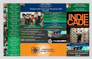
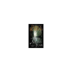
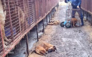
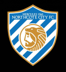
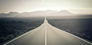
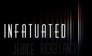

In [ ]:
# ===============================
# Case analysis of CLARA variants
# ===============================
import os, io, base64, html, numpy as np, torch
import torch.nn.functional as F
from PIL import Image
from IPython.display import HTML, display
from sklearn.metrics import accuracy_score, f1_score

# ---------- helpers ----------
id2name      = {0:"positive", 1:"neutral", 2:"negative"}
id2name_cap  = {0:"Positive", 1:"Neutral", 2:"Negative"}
id2abbr      = {0:"P", 1:"NT", 2:"NG"}

def _mark(pred_id, true_id):
    return f"{id2abbr[int(pred_id)]} " + ("(✓)" if int(pred_id)==int(true_id) else "(×)")

def _short_text(s, n=90):
    s = (s or "").replace("\n", " ").strip()
    return (s[:n] + "…") if len(s) > n else s

def _thumb_b64(path, size=(92,72)):
    try:
        im = Image.open(path).convert("RGB"); im.thumbnail(size)
    except Exception:
        im = Image.new("RGB", size, (220,220,220))
    buf = io.BytesIO(); im.save(buf, format="PNG")
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("utf-8")

@torch.no_grad()
def _gt_for_loader(loader):
    Y=[]
    for b in loader:
        y = b["labels"]
        if torch.is_tensor(y): y = y.cpu().numpy()
        Y.extend(np.asarray(y).tolist())
    return np.array(Y, dtype=np.int64)

@torch.no_grad()
def _forward_feats(model, pv, ids, msk):
    # Vision mean-pool + Text mask-mean
    v_out = model.vision(pv); v_feat = v_out.last_hidden_state.mean(1)
    t_out = model.text(input_ids=ids, attention_mask=msk)
    t_seq = t_out.last_hidden_state; mask = msk.unsqueeze(-1).float()
    t_feat = (t_seq * mask).sum(1) / mask.sum(1).clamp(min=1.0)
    return v_feat, t_feat

def _hidden_dim(model, default=512):
    return int(getattr(model, 'hidden_dim', getattr(getattr(model, 'cfg', {}), 'hidden_dim', default)))

# ---------- prediction pipelines ----------
@torch.no_grad()
def _predict_clara(model, loader, device):
    """CLARA (Ours): CoAttn → (Pred,Veri) → Feedback → Pred cuối"""
    P=[]
    for b in loader:
        pv=b['pixel_values'].to(device); ids=b['input_ids'].to(device); m=b['attention_mask'].to(device)
        v_feat, t_feat = _forward_feats(model, pv, ids, m)
        fused = model.fusion(v_feat, t_feat)
        lg_p, pr_p = model.pred(fused);  pr_p = F.softmax(lg_p, dim=-1) if pr_p is None else pr_p
        lg_v, pr_v = model.veri(fused);  pr_v = F.softmax(lg_v, dim=-1) if pr_v is None else pr_v
        ref = model.feed(fused, (pr_v - pr_p))  # diff trên probs
        lg, pr = model.pred(ref)
        P.extend((lg.argmax(-1)).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)

@torch.no_grad()
def _predict_wo_verification(model, loader, device):
    P=[]
    for b in loader:
        pv=b['pixel_values'].to(device); ids=b['input_ids'].to(device); m=b['attention_mask'].to(device)
        v_feat, t_feat = _forward_feats(model, pv, ids, m)
        fused = model.fusion(v_feat, t_feat)
        lg, _ = model.pred(fused)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)

@torch.no_grad()
def _predict_wo_feedback(model, loader, device):
    P=[]
    for b in loader:
        pv=b['pixel_values'].to(device); ids=b['input_ids'].to(device); m=b['attention_mask'].to(device)
        v_feat, t_feat = _forward_feats(model, pv, ids, m)
        fused = model.fusion(v_feat, t_feat)
        lg_p, _ = model.pred(fused); _ , _ = model.veri(fused)
        P.extend(lg_p.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)

@torch.no_grad()
def _predict_wo_coattn(model, loader, device):
    H = _hidden_dim(model)
    P=[]
    for b in loader:
        pv=b['pixel_values'].to(device); ids=b['input_ids'].to(device); m=b['attention_mask'].to(device)
        v_feat, t_feat = _forward_feats(model, pv, ids, m)
        v_h = model.fusion.v_proj(v_feat); t_h = model.fusion.t_proj(t_feat)
        fused = F.layer_norm(0.5*(v_h + t_h), (H,))
        lg, _ = model.pred(fused)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)

@torch.no_grad()
def _predict_text_only(model, loader, device):
    P=[]
    for b in loader:
        ids=b['input_ids'].to(device); m=b['attention_mask'].to(device)
        t_out = model.text(input_ids=ids, attention_mask=m)
        t_seq = t_out.last_hidden_state; mask = m.unsqueeze(-1).float()
        t_feat = (t_seq * mask).sum(1) / mask.sum(1).clamp(min=1.0)
        h = model.fusion.t_proj(t_feat)
        lg, _ = model.pred(h)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)

@torch.no_grad()
def _predict_vision_only(model, loader, device):
    P=[]
    for b in loader:
        pv=b['pixel_values'].to(device)
        v_out = model.vision(pv); v_feat = v_out.last_hidden_state.mean(1)
        h = model.fusion.v_proj(v_feat)
        lg, _ = model.pred(h)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)

# ---------- compute predictions ----------
y_true_np   = _gt_for_loader(test_loader)
pred_wo_ver = _predict_wo_verification(model, test_loader, device)
pred_wo_fb  = _predict_wo_feedback(model, test_loader, device)
pred_wo_ca  = _predict_wo_coattn(model, test_loader, device)
pred_text   = _predict_text_only(model, test_loader, device)
pred_vision = _predict_vision_only(model, test_loader, device)
pred_ours   = _predict_clara(model, test_loader, device)

# ---------- RANDOM Sample ----------
def _pick_indices_weighted_random(y_true, pred_ours, others_preds, k=6, alpha=2.0):

    idx_correct = np.where(pred_ours == y_true)[0]
    if len(idx_correct) == 0:
        return []

    others = np.stack(others_preds, axis=0)   # [M, N]
    y = y_true[None, :]                       # [1, N]
    wrong_mat = (others != y)                 # [M, N]
    wrong_count = wrong_mat[:, idx_correct].sum(axis=0).astype(float)  # [Nc]

    eps = 1e-6
    # add small jitter to break tie randomly
    jitter = np.random.uniform(0, 1e-3, size=wrong_count.shape)
    weights = (wrong_count + jitter + eps) ** alpha
    weights = weights / weights.sum()

    size = min(k, len(idx_correct))
    chosen = np.random.choice(idx_correct, size=size, replace=False, p=weights)
    return chosen.tolist()

others_list = [pred_wo_ver, pred_wo_fb, pred_wo_ca, pred_text, pred_vision]
sample_indices = _pick_indices_weighted_random(
    y_true_np, pred_ours, others_list, k=6, alpha=2.0
)

# ---------- render HTML table ----------
def render_case_table(indices, title="Case analysis of CLARA variants (MVSA-Single)"):
    if len(indices) == 0:
        print("Không tìm thấy mẫu thỏa điều kiện (CLARA-đúng). Hãy giảm điều kiện hoặc tăng k.")
        return

    have_samples = 'test_samples' in globals()
    head_cols = ["Sample","Text","Image","True value",
                 "w/o Verification","w/o Feedback","w/o Co-Attention",
                 "Text-only","Image-only","CLARA (Ours)"]
    thead = "".join([f'<th style="padding:8px; border:1px solid #eee; text-align:center;">{c}</th>' for c in head_cols])

    rows_html=[]
    for idx_k, i in enumerate(indices):
        if have_samples:
            s_text = getattr(test_samples[i], 'text', '')
            s_img  = getattr(test_samples[i], 'image_path', None)
        else:
            s_text, s_img = '', None

        text_short = html.escape(_short_text(s_text, 90))
        if s_img and os.path.exists(s_img):
            img_b64 = _thumb_b64(s_img)
            img_tag = f'<img src="{img_b64}" style="border-radius:6px;border:1px solid #ddd;">'
        else:
            img_tag = '<div style="width:92px;height:72px;border:1px dashed #ccc;border-radius:6px;background:#fafafa;"></div>'
        true_name = id2name_cap[int(y_true_np[i])]

        rows_html.append(f"""
        <tr>
          <td style="text-align:center;">({chr(ord('a')+idx_k)})</td>
          <td style="vertical-align:middle; width:30%;">{text_short}</td>
          <td style="text-align:center;">{img_tag}</td>
          <td style="text-align:center;">{true_name}</td>
          <td style="text-align:center;">{_mark(pred_wo_ver[i],  y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_wo_fb[i],   y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_wo_ca[i],   y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_text[i],    y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_vision[i],  y_true_np[i])}</td>
          <td style="text-align:center; font-weight:600;">{_mark(pred_ours[i],   y_true_np[i])}</td>
        </tr>
        """)

    # (Optional) global metrics
    variants = {
        "w/o Verification": pred_wo_ver,
        "w/o Feedback":     pred_wo_fb,
        "w/o Co-Attention": pred_wo_ca,
        "Text-only":        pred_text,
        "Image-only":       pred_vision,
        "CLARA (Ours)":     pred_ours
    }
    lines = []
    for name, P in variants.items():
        acc = accuracy_score(y_true_np, P)
        fw  = f1_score(y_true_np, P, average='weighted')
        lines.append(f"{name}: Acc={acc:.4f} | F1-Weighted={fw:.4f}")
    metrics_html = "<br>".join(lines)

    html_table = f"""
    <div style="margin:8px 0;">
      <h4 style="margin:6px 0;">{html.escape(title)}</h4>
      <table style="width:100%; border-collapse:collapse; font-family:Arial, sans-serif; font-size:14px;">
        <thead><tr style="background:#f7f7f7;">{thead}</tr></thead>
        <tbody>{''.join(rows_html)}</tbody>
      </table>
      <div style="font-size:12px; color:#666; margin-top:6px;">*P = Positive, NT = Neutral, NG = Negative</div>
      <div style="font-size:13px; color:#444; margin-top:10px;">
        <b>Dataset-wide metrics</b><br>{metrics_html}
      </div>
    </div>
    """
    display(HTML(html_table))

render_case_table(sample_indices)
